<a href="https://colab.research.google.com/github/chaewoncutie/ADV-ML-tests/blob/main/KMeans_GMM_Tuning_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install necessary packages
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn

In [6]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score, precision_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud
import numpy as np
import umap
from google.colab import files

In [11]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
df = pd.read_json(next(iter(uploaded)), lines=True)
df = df[['headline', 'short_description']].dropna()
df['text'] = df['headline'] + " " + df['short_description']

df.head()

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3.json


headline  \
0  Over 4 Million Americans Roll Up Sleeves For O...   
1  American Airlines Flyer Charged, Banned For Li...   
2  23 Of The Funniest Tweets About Cats And Dogs ...   
3  The Funniest Tweets From Parents This Week (Se...   
4  Woman Who Called Cops On Black Bird-Watcher Lo...   

                                   short_description  \
0  Health experts said it is too early to predict...   
1  He was subdued by passengers and crew when he ...   
2  "Until you have a dog you don't understand wha...   
3  "Accidentally put grown-up toothpaste on my to...   
4  Amy Cooper accused investment firm Franklin Te...   

                                                text  
0  Over 4 Million Americans Roll Up Sleeves For O...  
1  American Airlines Flyer Charged, Banned For Li...  
2  23 Of The Funniest Tweets About Cats And Dogs ...  
3  The Funniest Tweets From Parents This Week (Se...  
4  Woman Who Called Cops On Black Bird-Watcher Lo...

In [12]:
# Limit dataset size for faster processing
df = df.sample(n=50000, random_state=42)

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [13]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [14]:
# TF-IDF Vectorization with optimized parameters
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2), max_df=0.8, min_df=10)
X = vectorizer.fit_transform(df['filtered_text'])

In [16]:
# ----------------- SVD COMPONENT SELECTION -----------------
n_components_range = range(10, 101, 10)
explained_variance = []

for n in n_components_range:
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_svd_temp = svd.fit_transform(X)
    explained_variance.append(svd.explained_variance_ratio_.sum())
    print(f'n_components={n}, explained variance={svd.explained_variance_ratio_.sum():.4f}')

# Select the best number of components
# If none reach 90%, select the one with the highest explained variance
best_n_components = n_components_range[-1] # Initialize with the last value
max_explained_variance = 0

for n, ev in zip(n_components_range, explained_variance):
    if ev >= 0.90:
        best_n_components = n
        break  # Stop if we find one that meets the threshold
    elif ev > max_explained_variance:
        max_explained_variance = ev
        best_n_components = n # Update to the one with highest variance so far

print(f'Selected n_components for SVD: {best_n_components}')

# Apply Truncated SVD with the best n_components
svd = TruncatedSVD(n_components=best_n_components, random_state=42)
X_svd = svd.fit_transform(X)

n_components=10, explained variance=0.0295
n_components=20, explained variance=0.0514
n_components=30, explained variance=0.0701
n_components=40, explained variance=0.0865
n_components=50, explained variance=0.1015
n_components=60, explained variance=0.1150
n_components=70, explained variance=0.1276
n_components=80, explained variance=0.1392
n_components=90, explained variance=0.1503
n_components=100, explained variance=0.1611
Selected n_components for SVD: 100


In [17]:
# UMAP for further non-linear reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [19]:
# ----------------- HYPERPARAMETER TUNING -----------------

# Tune K-Means
best_k = None
best_score = -1
silhouette_scores = []
calinski_harabasz_scores = []
inertia_values = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++')
    kmeans_labels = kmeans.fit_predict(X_normalized)
    sil_score = silhouette_score(X_normalized, kmeans_labels)
    calinski_score = calinski_harabasz_score(X_normalized, kmeans_labels)
    inertia = kmeans.inertia_

    silhouette_scores.append(sil_score)
    calinski_harabasz_scores.append(calinski_score)
    inertia_values.append(inertia)

    print(f'k={k}, silhouette score={sil_score:.4f}, Calinski-Harabasz score={calinski_score:.4f}, inertia={inertia:.4f}')

    if sil_score > best_score:
        best_score = sil_score
        best_k = k

print(f"Optimal K for KMeans: {best_k}")

k=2, silhouette score=0.5617, Calinski-Harabasz score=80894.7603, inertia=4041.3108
k=3, silhouette score=0.5315, Calinski-Harabasz score=99370.9684, inertia=2126.6064
k=4, silhouette score=0.5573, Calinski-Harabasz score=124999.0011, inertia=1244.6277
k=5, silhouette score=0.5507, Calinski-Harabasz score=147566.5870, inertia=826.1686
k=6, silhouette score=0.5759, Calinski-Harabasz score=185664.8132, inertia=540.6579
k=7, silhouette score=0.5784, Calinski-Harabasz score=218423.3332, inertia=388.7734
k=8, silhouette score=0.5810, Calinski-Harabasz score=237688.7348, inertia=308.6265
k=9, silhouette score=0.5916, Calinski-Harabasz score=255841.1286, inertia=252.2515
k=10, silhouette score=0.5952, Calinski-Harabasz score=284312.5077, inertia=202.7427
k=11, silhouette score=0.5962, Calinski-Harabasz score=318891.7223, inertia=163.2983
k=12, silhouette score=0.5963, Calinski-Harabasz score=352679.9516, inertia=134.5941
k=13, silhouette score=0.5963, Calinski-Harabasz score=380179.0393, iner

In [20]:
# Train final K-Means with best K
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
df['kmeans_cluster'] = kmeans_final.fit_predict(X_normalized)

# Tune GMM
best_gmm = None
best_bic = float("inf")

for n in range(2, 15):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_normalized)

    bic = gmm.bic(X_normalized)  # Lower is better
    aic = gmm.aic(X_normalized)  # Lower is better

    print(f"GMM Components={n}, BIC={bic:.4f}, AIC={aic:.4f}")

    if bic < best_bic:
        best_bic = bic
        best_gmm = gmm

df['gmm_cluster'] = best_gmm.predict(X_normalized)
print(f"GMM clustering completed with best components={best_gmm.n_components}")

GMM Components=2, BIC=-65420.1578, AIC=-65517.1753
GMM Components=3, BIC=-147264.3967, AIC=-147414.3330
GMM Components=4, BIC=-205494.0094, AIC=-205696.8643
GMM Components=5, BIC=-255561.3012, AIC=-255817.0748
GMM Components=6, BIC=-299271.5265, AIC=-299580.2187
GMM Components=7, BIC=-336195.5501, AIC=-336557.1610
GMM Components=8, BIC=-364572.4336, AIC=-364986.9631
GMM Components=9, BIC=-372835.8348, AIC=-373303.2830
GMM Components=10, BIC=-402240.3685, AIC=-402760.7354
GMM Components=11, BIC=-419951.0088, AIC=-420524.2943
GMM Components=12, BIC=-434234.6629, AIC=-434860.8672
GMM Components=13, BIC=-470249.5785, AIC=-470928.7014
GMM Components=14, BIC=-468076.7333, AIC=-468808.7749
GMM clustering completed with best components=13


In [21]:
# ----------------- CLUSTERING EVALUATION -----------------

# Adjusted Rand Index (ARI) - How well the clusters match true labels
# ARI = 1 (perfect match), ARI = 0 (random clustering)
ari_kmeans = adjusted_rand_score(df['kmeans_cluster'], df['gmm_cluster'])
nmi_kmeans = normalized_mutual_info_score(df['kmeans_cluster'], df['gmm_cluster'])

print(f"Adjusted Rand Index (KMeans vs GMM): {ari_kmeans:.4f}")
print(f"Normalized Mutual Information (KMeans vs GMM): {nmi_kmeans:.4f}")

Adjusted Rand Index (KMeans vs GMM): 0.8417
Normalized Mutual Information (KMeans vs GMM): 0.9113


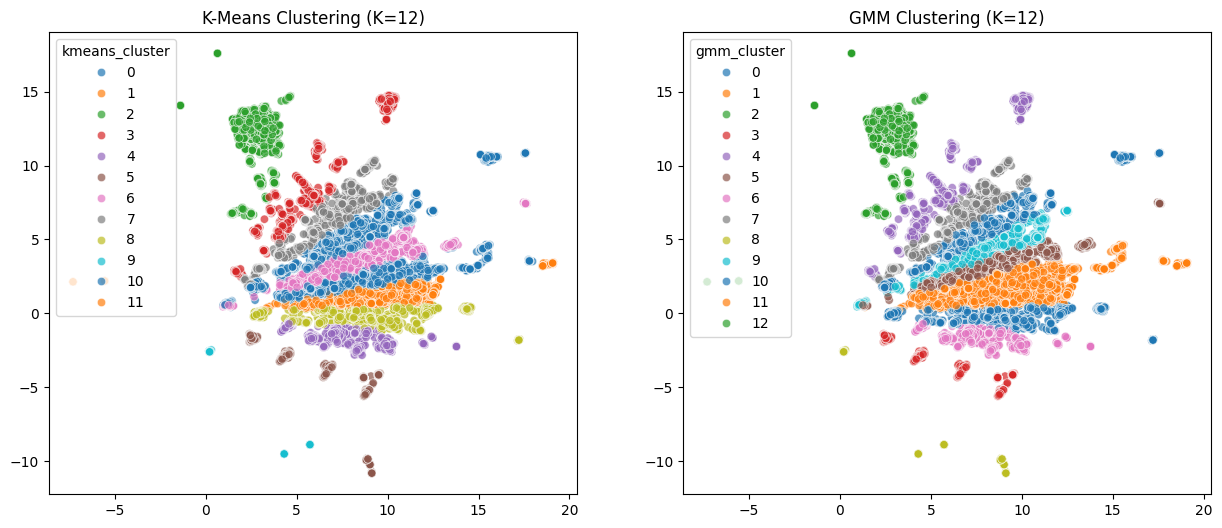

Clustering visualization completed.


In [22]:
# ----------------- CLUSTERING VISUALIZATION -----------------

# Plot Clusters
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['kmeans_cluster'], palette='tab10', alpha=0.7, ax=axes[0])
axes[0].set_title(f'K-Means Clustering (K={best_k})')

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['gmm_cluster'], palette='tab10', alpha=0.7, ax=axes[1])
axes[1].set_title(f'GMM Clustering (K={best_k})')

plt.show()
print("Clustering visualization completed.")

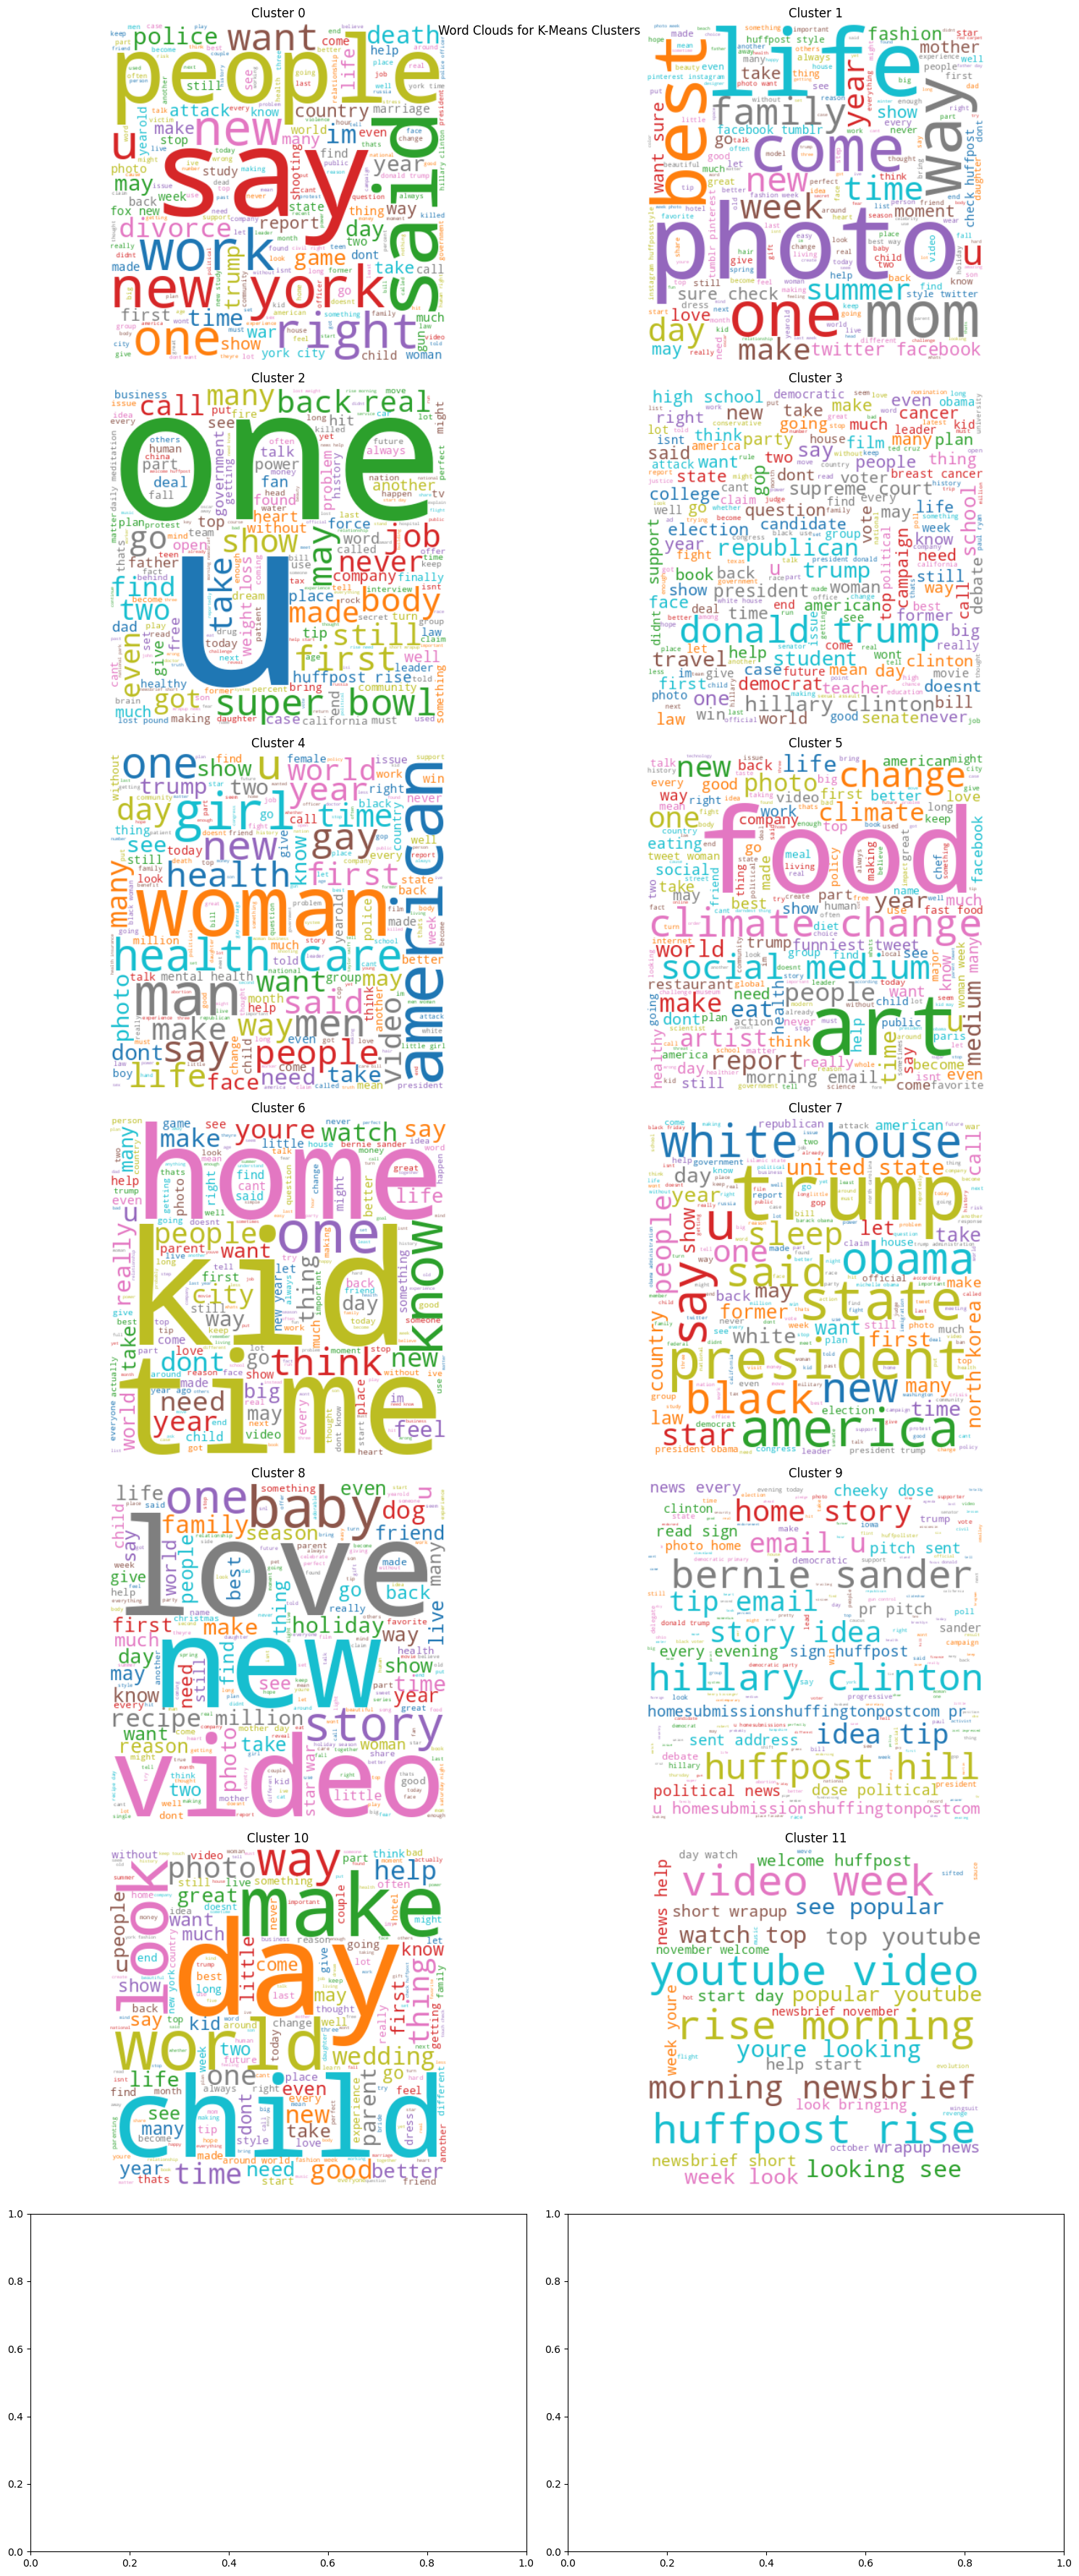

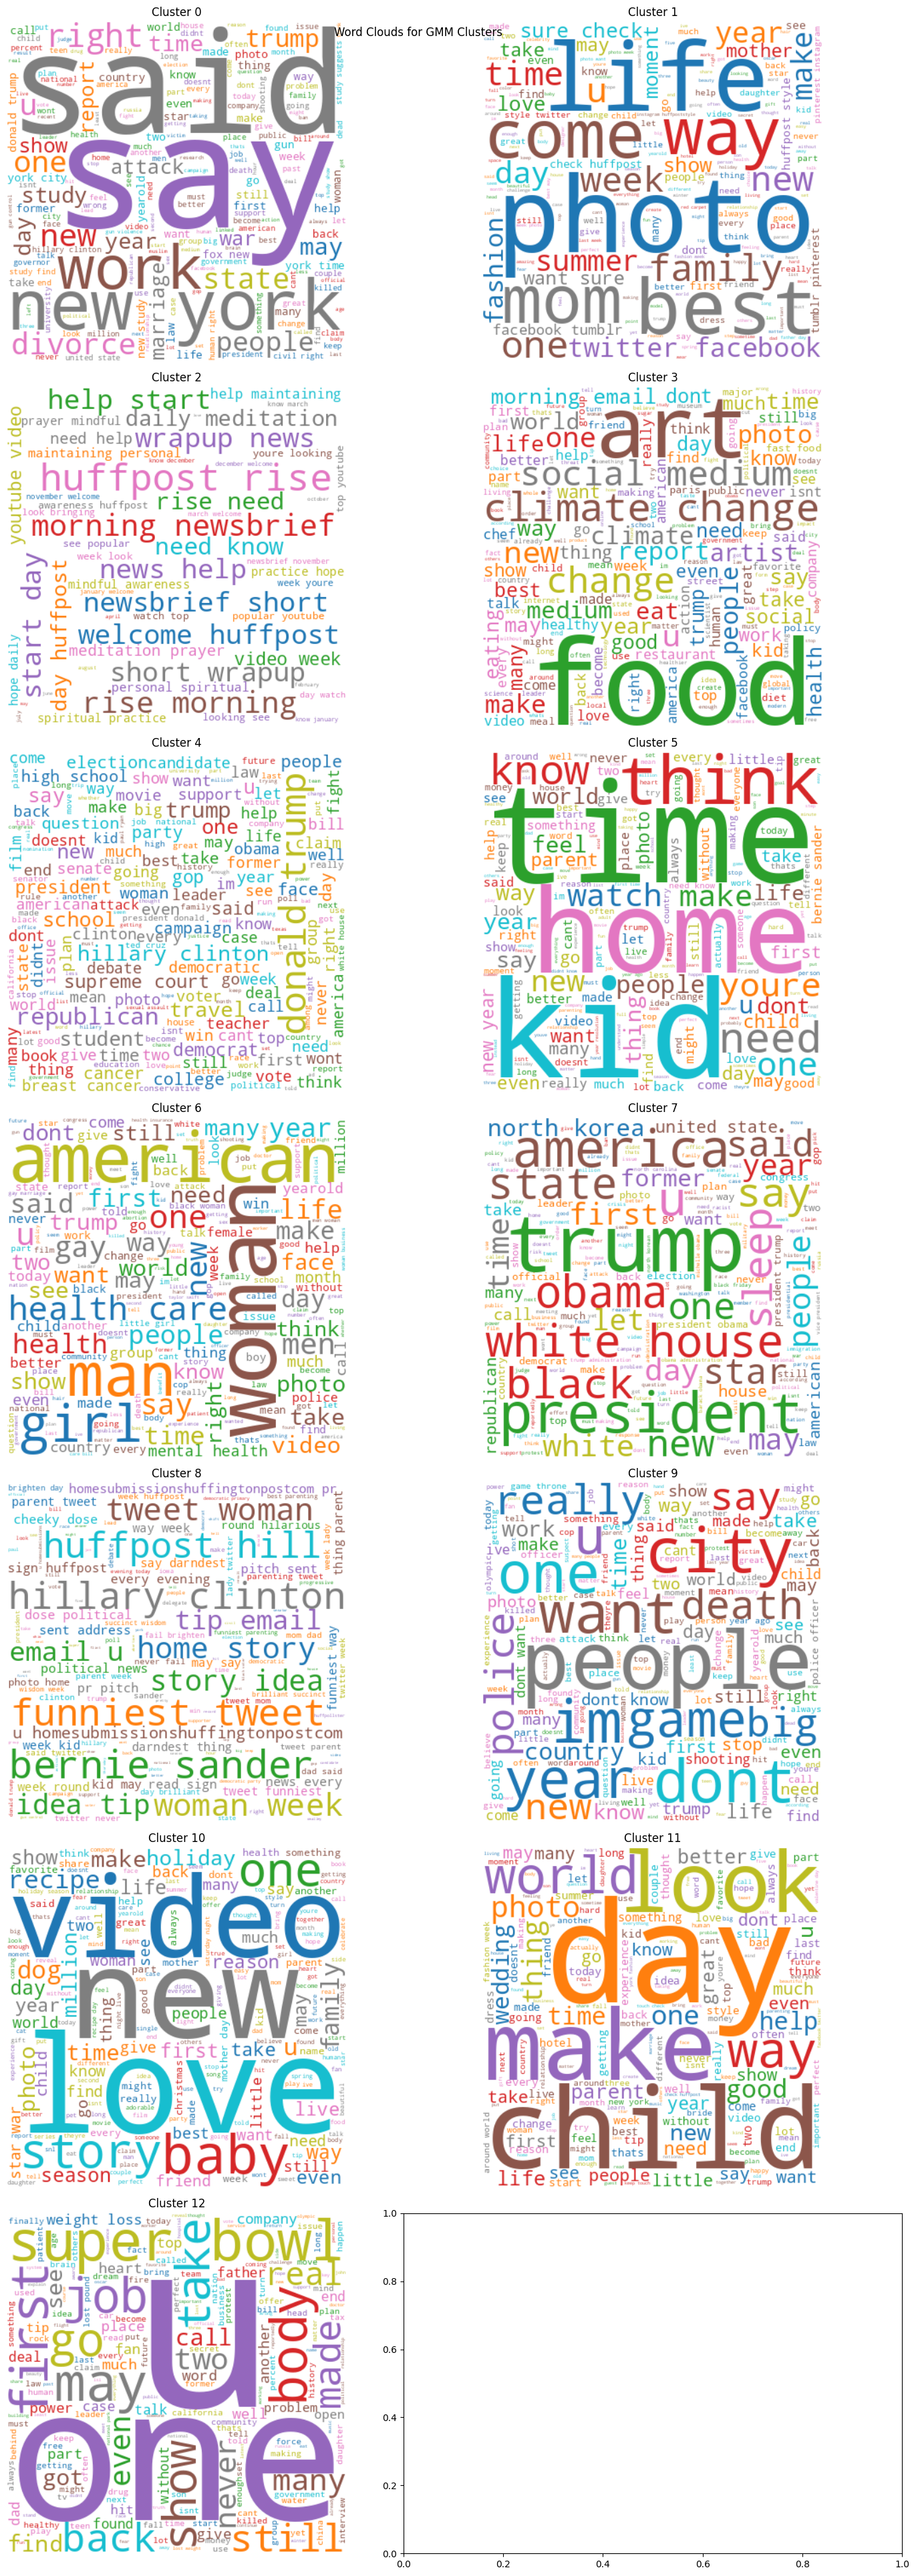

Word cloud visualization completed.


In [23]:
# ----------------- WORD CLOUD VISUALIZATION -----------------

def plot_wordclouds(df, cluster_column, model_name):
    clusters = sorted(df[cluster_column].unique())

    fig, axes = plt.subplots((len(clusters) // 2) + 1, 2, figsize=(15, len(clusters) * 3))
    axes = axes.flatten()

    for idx, cluster in enumerate(clusters):
        cluster_texts = df[df[cluster_column] == cluster]['filtered_text']
        wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='tab10').generate(' '.join(cluster_texts))

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Cluster {cluster}')
        axes[idx].axis('off')

    plt.suptitle(f'Word Clouds for {model_name} Clusters')
    plt.tight_layout()
    plt.show()

# Plot Word Clouds for KMeans and GMM
plot_wordclouds(df, 'kmeans_cluster', 'K-Means')
plot_wordclouds(df, 'gmm_cluster', 'GMM')

print("Word cloud visualization completed.")